In [1]:
import numpy as np
import pandas as pd
import os
from glob import glob
from pprint import pprint
import json
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib as matplotlib
import cmocean
import matplotlib.pyplot as plt

import cellcycle.PlottingTools as plottingTools
from cellcycle.ParameterSet import ParameterSet
import cellcycle.DataStorage as dataStorage
import cellcycle.DataAnalysis as dataAnalysis
import cellcycle.MakeDataframe as makeDataframe
from cellcycle import mainClass

In [2]:
file_path_input_params_json = '../../input_params.json'
input_param_dict = mainClass.extract_variables_from_input_params_json(file_path_input_params_json)
root_path = input_param_dict["DATA_FOLDER_PATH"]
simulation_location = 'SI/S15_Optimised_switch_titration/Optimisation'
file_path = os.path.join(root_path, simulation_location)
print('file_path', file_path)
parameter_path = os.path.join(file_path, 'parameter_set.csv')
print('parameter_path', parameter_path)

file_path /home/berger/Data/UltrasensitivityCombined/Final_NatCom_Submission/SI/S15_Optimised_switch_titration/Optimisation
parameter_path /home/berger/Data/UltrasensitivityCombined/Final_NatCom_Submission/SI/S15_Optimised_switch_titration/Optimisation/parameter_set.csv


In [3]:
pinkish_red = (247 / 255, 109 / 255, 109 / 255)
green = (0 / 255, 133 / 255, 86 / 255)
dark_blue = (36 / 255, 49 / 255, 94 / 255)
light_blue = (168 / 255, 209 / 255, 231 / 255)
blue = (55 / 255, 71 / 255, 133 / 255)
yellow = (247 / 255, 233 / 255, 160 / 255)

colors = [blue, pinkish_red, green, yellow, light_blue]

## General parameters

In [4]:
total_conc_0 = 400
v_init_0 = 0.28
dt=0.001

## Parameters titration

In [5]:
KD_sites = 1
n_s = 300
crit_free_conc = 233.14730264
total_conc_titr = 1300

## Parameters switch

In [6]:
activation_rate_0 = total_conc_0 / 400 * 2142
deactivation_rate_0 = total_conc_0 / 400 * 600
diss_const_activation_0 = total_conc_0 / 400 * 50
diss_const_deactivation_0 = total_conc_0 / 400 * 50

frac_init = 0.5

# Functions to calculate free conc and active frac

In [7]:
def calculate_free_conc(volume, total_conc, KD_sites, n_s):
    a = KD_sites + n_s/volume + total_conc
    return total_conc- a/2 + np.sqrt(a**2 - 4 * n_s/volume * total_conc)/2

def calculate_active_frac(volume, total_conc, diss_const_activation, diss_const_deactivation, activation_rate, deactivation_rate):
    a = activation_rate * volume - deactivation_rate
    b = deactivation_rate * (1 + diss_const_activation / total_conc) \
        - activation_rate * volume * (1 - diss_const_deactivation / total_conc)
    c = - activation_rate * volume * diss_const_deactivation / total_conc
    return (-b + np.sqrt(b**2 - 4 * a * c))/(2 * a)

def calculate_lipid_from_v_init(total_conc, diss_const_activation, diss_const_deactivation, deactivation_rate, v_init):
    return deactivation_rate / v_init * frac_init * (diss_const_activation / total_conc + 1 - frac_init) / \
           ((1 - frac_init) * (diss_const_deactivation/ total_conc + frac_init))

def solve_crit_conc(crit_free_conc, total_conc, KD_sites, n_s, v_init):
    a = KD_sites + n_s/v_init + total_conc
    return total_conc- a/2 + np.sqrt(a**2 - 4 * n_s/v_init * total_conc)/2 - crit_free_conc

In [8]:
from scipy.optimize import fsolve

print(calculate_lipid_from_v_init(total_conc_0, diss_const_activation_0, diss_const_deactivation_0, deactivation_rate_0, v_init_0))
crit_free_conc = fsolve(solve_crit_conc, x0=[200], args= (total_conc_titr, KD_sites, n_s, v_init_0))[0]
print('critical free conc:', crit_free_conc)

2142.8571428571427
critical free conc: 233.1473026444091


# Calculate variances

In [9]:
std_active_frac = 0.08

In [10]:
def calculate_active_frac_sympy(volume, total_conc, diss_const_activation, diss_const_deactivation, activation_rate, deactivation_rate):
    a = activation_rate * volume - deactivation_rate
    b = deactivation_rate * (1 + diss_const_activation / total_conc) \
        - activation_rate * volume * (1 - diss_const_deactivation / total_conc)
    c = - activation_rate * volume * diss_const_deactivation / total_conc
    return (-b + sympy.sqrt(b**2 - 4 * a * c))/(2 * a)

def calculate_free_conc_sympy(volume, total_conc, KD_sites, n_s):
    a = KD_sites + n_s/volume + total_conc
    return total_conc- a/2 + sympy.sqrt(a**2 - 4 * n_s/volume * total_conc)/2

def calculate_gain_combined(deriv_f, deriv_free_conc, frac_init, crit_free_conc):
    return deriv_f * crit_free_conc + deriv_free_conc * frac_init

def std_volume_given_std_frac(std, gain):
    return std /gain

In [11]:
from sympy import *
import sympy as sympy
v = symbols('v')
init_printing(use_unicode=True)

deriv_f =diff(calculate_active_frac_sympy(v, 
                          total_conc_0, 
                          diss_const_activation_0, 
                          diss_const_deactivation_0, 
                          activation_rate_0, 
                          deactivation_rate_0), v)
deriv_f_lambdified = lambdify(v, deriv_f)
print(deriv_f_lambdified(v_init_0))
std_volume_switch = std_volume_given_std_frac(std_active_frac, deriv_f_lambdified(v_init_0))
print(std_volume_switch)

4.464274815813951
0.017920043747444336


In [12]:
derif_free_conc = diff(calculate_free_conc_sympy(v, 
                                                 total_conc_titr, 
                                                 KD_sites,
                                                 n_s), v)
derif_free_conc_lambdified = lambdify(v, derif_free_conc)
print(derif_free_conc_lambdified(v_init_0)/crit_free_conc)

16.02915420640075


In [13]:
gain_combined = calculate_gain_combined(deriv_f_lambdified(v_init_0), 
                                        derif_free_conc_lambdified(v_init_0), 
                                        frac_init, 
                                        crit_free_conc)/crit_free_conc
print('gain combined', gain_combined)
std_volume_combined = std_volume_given_std_frac(std_active_frac, gain_combined)
print(std_volume_combined)

gain combined 12.478851919014328
0.006410846167514983


# Combining switch and titration plot

In [14]:
volume = np.arange(0.01, 1, 0.001)
free_conc = calculate_free_conc(volume, total_conc_titr, KD_sites, n_s)
active_fraction = calculate_active_frac(volume, total_conc_0, 
                                        diss_const_activation_0, 
                                        diss_const_deactivation_0, 
                                        activation_rate_0, 
                                        deactivation_rate_0)
scaling_factor_f= 0.01
scaling_factor_v= 0.005

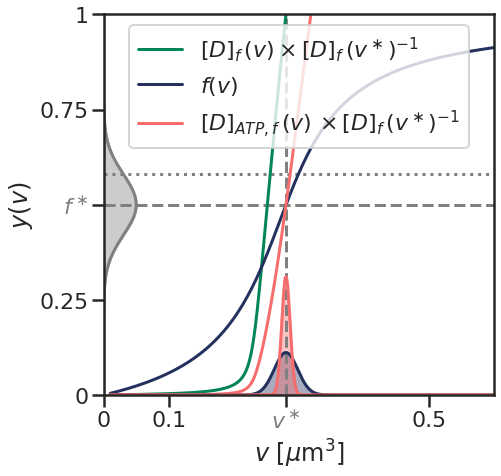

In [15]:
from scipy.stats import norm

sns.set(style="ticks")
sns.set_context("poster")

fig, ax = plt.subplots(figsize=(7,7))
ax.plot(volume, free_conc / crit_free_conc, label= r'$[D]_f\,(v) \times [D]_f\,(v^\ast)^{-1}$', color=green)
ax.plot(volume, active_fraction, label= '$f(v)$', color=dark_blue)
ax.plot(volume, 
        free_conc * active_fraction / crit_free_conc, 
        label= r'$[D]_{ATP,f}\,(v)\, \times [D]_f\,(v^\ast)^{-1}$',
        color = pinkish_red)
# ax.hlines(crit_free_conc, xmin=0, xmax=1, linestyle='--')
ax.vlines(0.28, ymin=0, ymax=1, linestyle='--', color= 'grey')


ax.set_yticks([0,0.25, frac_init, 0.75, 1])
ax.set_yticklabels(['0','0.25',r'$f^\ast$','0.75', '1'])
ax.hlines(0.5, xmin=0, xmax=1, linestyle='--', color= 'grey')
ax.get_yticklabels()[2].set_color('grey')

ax.set_xticks([0, 0.1,  0.28, 0.5])
ax.set_xticklabels(['0','0.1', r'$v^\ast$', '0.5'])
ax.get_xticklabels()[2].set_color('grey')

# Make Gaussian distributions
y_axis = np.arange(0, 1, 0.001)
gaussian_f = norm.pdf(y_axis,frac_init,std_active_frac)*scaling_factor_f
gaussian_v_switch = norm.pdf(volume,v_init_0,std_volume_switch)*scaling_factor_v
gaussian_v_combined = norm.pdf(volume,v_init_0,std_volume_combined)*scaling_factor_v
plt.plot(gaussian_f, y_axis, color= 'grey')
plt.fill_between( gaussian_f,y_axis, step="pre", alpha=0.4, color= 'grey')

plt.plot(volume, gaussian_v_switch, color = dark_blue)
plt.fill_between(volume, gaussian_v_switch, step="pre", alpha=0.4, color = dark_blue)

plt.plot(volume, gaussian_v_combined, color = pinkish_red)
plt.fill_between(volume, gaussian_v_combined, step="pre", alpha=0.4, color = pinkish_red)

# Plot arrows

ax.hlines(frac_init+std_active_frac, 
          xmin=0, 
          xmax=1, 
          linestyle='dotted', 
          color= 'grey')


ax.set(xlabel=r'$v$ [$\mu$m$^3$]', ylabel=r'$y(v)$')
ax.legend(loc='upper center')
ax.margins(0)
ax.set(xlim=(0, 0.6))
ax.set(ylim=(0, 1))
plt.savefig(file_path + '/gain_increased.pdf', format='pdf', bbox_inches='tight')

# Plot derivatives

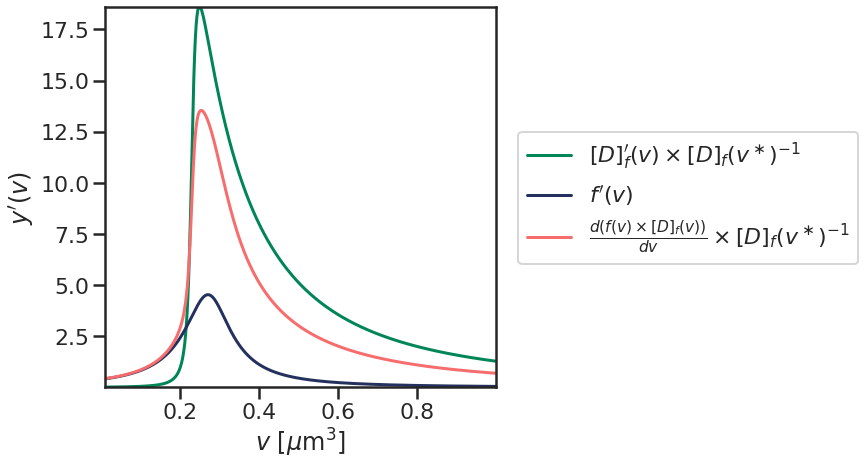

In [16]:
from scipy.stats import norm

sns.set(style="ticks")
sns.set_context("poster")

gain_combined_volume = calculate_gain_combined(deriv_f_lambdified(volume), 
                                        derif_free_conc_lambdified(volume), 
                                        frac_init, 
                                        crit_free_conc)/crit_free_conc

fig, ax = plt.subplots(figsize=(7,7))
ax.plot(volume, derif_free_conc_lambdified(volume)/crit_free_conc, label= r'$[D]_f^\prime (v) \times [D]_f(v^\ast)^{-1}$', color=green)
ax.plot(volume, deriv_f_lambdified(volume), label= '$f^\prime(v)$', color=dark_blue)
ax.plot(volume, gain_combined_volume, 
        label= r'$\frac{d(f(v) \times [D]_f(v))}{dv}\times [D]_f(v^\ast)^{-1}$',
        color = pinkish_red)

ax.set(xlabel=r'$v$ [$\mu$m$^3$]', ylabel=r'$y^\prime(v)$')
ax.legend(bbox_to_anchor=(1.03, 0.7))
ax.margins(0)
# ax.set(xlim=(0, 0.6))
# ax.set(ylim=(0, 1))
plt.savefig(file_path + '/plot_derivatives.pdf', format='pdf', bbox_inches='tight')